In [2]:
!pip install qiskit #this is just me intalling qiskit into our notebook
!pip install matplotlib plotly #since it says we need a 3d structure to simulate the lattice and any other 3d elements
!pip install numpy
!pip install qiskit-aer


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 99.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import Aer  # Fixed import
from scipy.optimize import minimize
from typing import List, Dict, Tuple
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import Aer  # Fixed import
from scipy.optimize import minimize
from typing import List, Dict, Tuple

"""
proteins fold in 3D space and here we're working with a simplified lattice model w tetrahedral directions. There are two kinds of alternating sites in the protein chain: 'A' and 'B'.
every turn corresponds to a direction in 3D space either x,y or z
The vectors  [1, 1, 1]) are unit steps in different directions based on the protein structure model.
"""

class SparseDiamondEncoder:
    """Encodes/decodes backbone turns on a diamond (tetrahedral) lattice."""

    # sublattice A basis (even sites)
    _A: Dict[int,np.ndarray] = {
        0: np.array([+1,+1,+1]),    # |00> This is for the first round of qubits represents x,y,z
        1: np.array([+1,-1,-1]),    # |10>
        2: np.array([-1,+1,-1]),    # |01>
        3: np.array([-1,-1,+1]),    # |11>
    }
    # sublattice B basis (odd sites)
    _B: Dict[int,np.ndarray] = {
        0: np.array([+1,+1,-1]),    # |00>
        1: np.array([+1,-1,+1]),    # |10>
        2: np.array([-1,+1,+1]),    # |01>
        3: np.array([-1,-1,-1]),    # |11>
    }

    @staticmethod
    def site_parity(i):
        """Return 'A' if turn index i is even (sublattice A), else 'B'."""
        return 'A' if i % 2 == 0 else 'B'

    @classmethod
    def block_to_vec(cls, block, i):
        """
        Decode one-hot 4-bit string (e.g. '1000') at turn index i into a 3D step vector.
        Raises ValueError if block is not one-hot of length 4.
        """
        if len(block) != 4 or block.count('1') != 1:
            raise ValueError(f"Invalid block {block}, must be one-hot length 4.")
        axis = ['1000','0100','0010','0001'].index(block)
        if cls.site_parity(i) == 'A':
            table = cls._A
        else:
            table = cls._B
        return table[axis]

    @classmethod
    def bitstring_to_turns(cls, bitstr, N):
        """
        Convert full measured bitstring (length=4*(N-3)) into list of N-1 turn vectors:
        - t1 = (+1,+1,+1)
        - t2 = (+1,-1,-1)
        - t3..t_{N-1} from blocks of 4 bits
        """
        bitstr = bitstr.replace(" ", "")
        expected = 4*(N-3)
        if len(bitstr) != expected:
            raise ValueError(f"Expected bitstring length {expected}, got {len(bitstr)}")
        turns: List[np.ndarray] = []
        # fixed first two turns
        turns.append(cls._A[0])  # t1
        turns.append(cls._A[1])  # t2
        # decode remaining
        for k, start in enumerate(range(0, expected, 4), start=3):
            block = bitstr[start:start+4]
            turns.append(cls.block_to_vec(block, k))
        return turns

    @classmethod
    def turns_to_valid_bitstring(cls, N):
        """Generate a valid one-hot encoded bitstring for testing."""
        n_variable_turns = N - 3
        bitstring = ""
        for i in range(n_variable_turns):
            # Create a one-hot block (randomly pick one position to be '1')
            block = ['0'] * 4
            block[np.random.randint(4)] = '1'
            bitstring += ''.join(block)
        return bitstring


def T(t_i: np.ndarray, t_j: np.ndarray) -> int:
    """
    Indicator: 1 if t_i and t_j lie on same lattice axis or opposite, else 0.
    """
    return int(np.array_equal(t_i, t_j) or np.array_equal(t_i, -t_j))


"""
Hamiltonian defines the cost Hamiltonian terms for a protein fold on a diamond lattice:

1. Growth Constraint (H_gc): penalises consecutive backtracking bonds.
2. Overlap Penalty (H_ov): penalises any pair of beads occupying the same site.
3. Contact Reward (H_ct): rewards non-bonded nearest neighbours.
4. Chirality Constraint (H_ch): enforces correct handedness per sublattice.
5. Interaction Stub (H_in): placeholder for shell-based interaction qubits.

Each method returns a classical float energy for the decoded turn list.
"""

MJ_MATRIX = {
    'C': {  # Cysteine
        'C': -5.44, 'M':  0.46, 'F': -0.20, 'I':  0.37, 'L':  0.31,
        'V':  0.17, 'W': -0.64, 'Y': -0.41, 'H': -0.73, 'P': -0.37,
        'G': -0.29, 'A': -6.10, 'S': -0.34, 'T': -0.29, 'D':  0.17,
        'E': -0.09, 'K':  0.02, 'R': -0.45, 'Q': -0.18, 'N': -0.03
    },
    'M': {  # Methionine
        'C':  0.46, 'M': -5.46, 'F': -0.24, 'I':  0.29, 'L':  0.27,
        'V':  0.18, 'W': -0.62, 'Y': -0.34, 'H': -0.47, 'P': -0.55,
        'G': -0.63, 'A': -5.74, 'S': -0.20, 'T': -0.16, 'D':  0.02,
        'E': -0.27, 'K':  0.06, 'R': -0.52, 'Q': -0.34, 'N': -0.67
    },
    'F': {  # Phenylalanine
        'C': -0.20, 'M': -0.24, 'F': -5.50, 'I':  0.15, 'L':  0.11,
        'V':  0.05, 'W':  0.59, 'Y':  0.39, 'H': -0.35, 'P': -0.56,
        'G': -0.70, 'A': -5.55, 'S': -0.53, 'T': -0.51, 'D': -0.63,
        'E': -0.63, 'K': -0.61, 'R': -0.61, 'Q': -0.49, 'N': -0.46
    },
    'I': {  # Isoleucine
        'C':  0.37, 'M':  0.29, 'F':  0.15, 'I': -5.75, 'L':  0.51,
        'V':  0.52, 'W':  0.58, 'Y':  0.23, 'H': -0.23, 'P': -0.67,
        'G': -0.58, 'A': -5.56, 'S': -0.40, 'T': -0.41, 'D': -0.40,
        'E': -0.43, 'K': -0.46, 'R': -0.33, 'Q': -0.44, 'N': -0.64
    },
    'L': {  # Leucine
        'C':  0.31, 'M':  0.27, 'F':  0.11, 'I':  0.51, 'L': -5.44,
        'V':  0.48, 'W':  0.28, 'Y':  0.10, 'H': -0.21, 'P': -0.61,
        'G': -0.51, 'A': -5.50, 'S': -0.29, 'T': -0.28, 'D': -0.33,
        'E': -0.35, 'K': -0.39, 'R': -0.21, 'Q': -0.31, 'N': -0.38
    },
    'V': {  # Valine
        'C':  0.17, 'M':  0.18, 'F':  0.05, 'I':  0.52, 'L':  0.48,
        'V': -5.07, 'W': -0.61, 'Y': -0.25, 'H': -0.37, 'P': -0.69,
        'G': -0.72, 'A': -5.44, 'S': -0.47, 'T': -0.39, 'D': -0.63,
        'E': -0.61, 'K': -0.49, 'R': -0.40, 'Q': -0.56, 'N': -0.88
    },
    'W': {  # Tryptophan
        'C': -0.64, 'M': -0.62, 'F':  0.59, 'I':  0.58, 'L':  0.28,
        'V': -0.61, 'W': -6.10, 'Y':  0.73, 'H': -0.07, 'P': -0.61,
        'G': -0.47, 'A': -5.86, 'S': -0.47, 'T': -0.46, 'D':  0.55,
        'E': -0.18, 'K': -0.04, 'R':  0.42, 'Q': -0.09, 'N': -0.21
    },
    'Y': {  # Tyrosine
        'C': -0.41, 'M': -0.34, 'F':  0.39, 'I':  0.23, 'L':  0.10,
        'V': -0.25, 'W':  0.73, 'Y': -5.50, 'H':  0.08, 'P': -0.58,
        'G': -0.59, 'A': -6.10, 'S': -0.14, 'T': -0.16, 'D':  0.08,
        'E': -0.11, 'K': -0.16, 'R': -0.30, 'Q': -0.24, 'N':  0.04
    },
    'H': {  # Histidine
        'C': -0.73, 'M': -0.47, 'F': -0.35, 'I': -0.23, 'L': -0.21,
        'V': -0.37, 'W': -0.07, 'Y':  0.08, 'H': -4.03, 'P': -0.43,
        'G':  0.09, 'A': -6.07, 'S':  0.17, 'T':  0.09, 'D':  0.35,
        'E':  0.27, 'K':  0.01, 'R':  0.31, 'Q':  0.35, 'N':  0.20
    },
    'P': {  # Proline
        'C': -0.37, 'M': -0.55, 'F': -0.56, 'I': -0.67, 'L': -0.61,
        'V': -0.69, 'W': -0.61, 'Y': -0.58, 'H': -0.43, 'P': -3.02,
        'G': -0.60, 'A': -5.43, 'S': -0.29, 'T': -0.33, 'D': -0.67,
        'E': -0.73, 'K': -0.46, 'R': -0.29, 'Q': -0.77, 'N': -0.60
    },
    'G': {  # Glycine
        'C': -0.29, 'M': -0.63, 'F': -0.70, 'I': -0.58, 'L': -0.51,
        'V': -0.72, 'W': -0.47, 'Y': -0.59, 'H':  0.09, 'P': -0.60,
        'G': -1.68, 'A': -5.64, 'S':  0.01, 'T': -0.01, 'D':  0.67,
        'E':  0.54, 'K': -0.38, 'R': -0.28, 'Q':  0.15, 'N':  0.38
    },
    'A': {  # Alanine
        'C': -6.10, 'M': -5.74, 'F': -5.55, 'I': -5.56, 'L': -5.50,
        'V': -5.44, 'W': -5.86, 'Y': -6.10, 'H': -6.07, 'P': -5.43,
        'G': -5.64, 'A': -5.28, 'S': -0.33, 'T': -0.69, 'D': -6.04,
        'E': -5.97, 'K': -6.02, 'R': -6.58, 'Q': -5.88, 'N': -5.78
    },
    'S': {  # Serine
        'C': -0.34, 'M': -0.20, 'F': -0.53, 'I': -0.40, 'L': -0.29,
        'V': -0.47, 'W': -0.47, 'Y': -0.14, 'H':  0.17, 'P': -0.29,
        'G':  0.01, 'A': -0.33, 'S': -6.12, 'T':  0.68, 'D':  0.88,
        'E':  0.71, 'K':  0.13, 'R':  0.22, 'Q':  0.36, 'N':  0.92
    },
    'T': {  # Threonine
        'C': -0.29, 'M': -0.16, 'F': -0.51, 'I': -0.41, 'L': -0.28,
        'V': -0.39, 'W': -0.46, 'Y': -0.16, 'H':  0.09, 'P': -0.33,
        'G': -0.01, 'A': -0.69, 'S':  0.68, 'T': -5.30, 'D':  0.72,
        'E':  0.55, 'K':  0.10, 'R':  0.13, 'Q':  0.30, 'N':  0.74
    },
    'D': {  # Aspartate
        'C':  0.17, 'M':  0.02, 'F': -0.63, 'I': -0.40, 'L': -0.33,
        'V': -0.63, 'W':  0.55, 'Y':  0.08, 'H':  0.35, 'P': -0.67,
        'G':  0.67, 'A': -6.04, 'S':  0.88, 'T':  0.72, 'D': -3.40,
        'E':  0.72, 'K': -0.15, 'R': -0.11, 'Q':  0.09, 'N':  0.77
    },
    'E': {  # Glutamate
        'C': -0.09, 'M': -0.27, 'F': -0.63, 'I': -0.43, 'L': -0.35,
        'V': -0.61, 'W': -0.18, 'Y': -0.11, 'H':  0.27, 'P': -0.73,
        'G':  0.54, 'A': -5.97, 'S':  0.71, 'T':  0.55, 'D':  0.72,
        'E': -4.90, 'K':  0.10, 'R': -0.02, 'Q':  0.55, 'N':  0.29
    },
    'K': {  # Lysine
        'C':  0.02, 'M':  0.06, 'F': -0.61, 'I': -0.46, 'L': -0.39,
        'V': -0.49, 'W': -0.04, 'Y': -0.16, 'H':  0.01, 'P': -0.46,
        'G': -0.38, 'A': -6.02, 'S':  0.13, 'T':  0.10, 'D': -0.15,
        'E':  0.10, 'K': -4.74, 'R':  0.84, 'Q': -0.15, 'N': -0.29
    },
    'R': {  # Arginine
        'C': -0.45, 'M': -0.52, 'F': -0.61, 'I': -0.33, 'L': -0.21,
        'V': -0.40, 'W':  0.42, 'Y': -0.30, 'H':  0.31, 'P': -0.29,
        'G': -0.28, 'A': -6.58, 'S':  0.22, 'T':  0.13, 'D': -0.11,
        'E': -0.02, 'K':  0.84, 'R': -4.36, 'Q':  0.03, 'N':  0.04
    },
    'Q': {  # Glutamine
        'C': -0.18, 'M': -0.34, 'F': -0.49, 'I': -0.44, 'L': -0.31,
        'V': -0.56, 'W': -0.09, 'Y': -0.24, 'H':  0.35, 'P': -0.77,
        'G':  0.15, 'A': -5.88, 'S':  0.36, 'T':  0.30, 'D':  0.09,
        'E':  0.55, 'K': -0.15, 'R':  0.03, 'Q': -3.05, 'N':  0.40
    },
    'N': {  # Asparagine
        'C': -0.03, 'M': -0.67, 'F': -0.46, 'I': -0.64, 'L': -0.38,
        'V': -0.88, 'W': -0.21, 'Y':  0.04, 'H':  0.20, 'P': -0.60,
        'G':  0.38, 'A': -5.78, 'S':  0.92, 'T':  0.74, 'D':  0.77,
        'E':  0.29, 'K': -0.29, 'R':  0.04, 'Q':  0.40, 'N': -3.16
    },
}

def build_weights_from(sequence: str) -> Dict[Tuple[int,int], float]:
    """
    For each non‑bonded pair (i,j) with |i−j|>2, assign the raw MJ contact energy.
    """
    N = len(sequence)
    weights: Dict[Tuple[int,int], float] = {}
    for i in range(N):
        for j in range(i+3, N):
            aa_i = sequence[i]
            aa_j = sequence[j]
            weights[(i, j)] = MJ_MATRIX[aa_i][aa_j]
    return weights


class Hamiltonian:
    def __init__(
        self,
        sequence: str, # amino acid sequence
        back_penalty_weight: float = 30.0,
        overlap_weight: float = 50.0,
        contact_reward: float = 10.0,
        chirality_weight: float = 40.0,
        interaction_weights=None,
    ):
        """
        Parameters:
        -----------
        N : Number of amino acids in the protein
        sequence : amino‐acid string, e.g. "MADYEK"
        turns : List of N-1 3D step vectors (np.ndarray).
        back_penalty_weight : λ_back for growth constraint.
        overlap_weight : λ_ov for overlap penalty.
        contact_reward : ε for contact reward (>0).
        chirality_weight : λ_chir for chirality penalty.
        """
        self.sequence = sequence
        self.N = len(sequence)
        self.total_qubits = 4 * (self.N - 3) # Fixed: added total_qubits attribute
        self.λ_back = back_penalty_weight
        self.λ_ov = overlap_weight
        self.ε = contact_reward
        self.λ_chir = chirality_weight
        self.interaction_weights = interaction_weights or {}
        # Build MJ weights if not provided
        if interaction_weights is None:
            self.interaction_weights = build_weights_from(sequence)
        else:
            self.interaction_weights = interaction_weights

    def calculate_energy(self, turns):
        """Calculate total energy for given turns."""
        return (
            self.growth_constraint(turns)
            + self.overlap_penalty(turns)
            + self.contact_reward(turns)  # Fixed method name
            + self.chirality_constraint(turns)
            + self.interaction_constraint(turns)
        )

    def total_energy(self, bitstring):
        """
        Calculate energy from bitstring by first decoding to turns.
        This is what CVARVQE calls.
        """
        try:
            turns = SparseDiamondEncoder.bitstring_to_turns(bitstring, self.N)
            return self.calculate_energy(turns)
        except ValueError:
            # If bitstring is invalid, return high penalty
            return 1000.0

    def growth_constraint(self, turns):
        """
        H_gc = λ_back * Σ_{i=3..N-1} T(t_i, t_{i+1}).
        """
        H_gc = 0.0
        for i in range(2, len(turns) - 1):
            H_gc += self.λ_back * T(turns[i], turns[i + 1])
        return H_gc

    def overlap_penalty(self, turns):
        """
        H_ov = λ_ov * Σ overlap penalty for beads at same position
        """
        pos = [(0, 0, 0)]
        for t in turns:
            prev = np.array(pos[-1])
            pos.append(tuple(prev + t))

        H_ov = 0.0
        # Check for overlaps
        for i in range(len(pos)):
            for j in range(i + 1, len(pos)):
                if pos[i] == pos[j]:
                    H_ov += self.λ_ov
        return H_ov

    def contact_reward(self, turns):  # Fixed method name
        """
        H_ct = -ε * Σ contact rewards for non-bonded nearest neighbors
        """
        pos = [(0, 0, 0)]
        for t in turns:
            prev = np.array(pos[-1])
            pos.append(tuple(prev + t))

        H_ct = 0.0
        # threshold for nearest neighbor on diamond lattice
        nn_dist = np.sqrt(3)
        tol = 1e-6
        for i in range(len(pos)):
            # |i-j|>2 for non-bonded neighbors
            for j in range(i + 3, len(pos)):
                d = np.linalg.norm(np.array(pos[i]) - np.array(pos[j]))
                if abs(d - nn_dist) < tol:
                    H_ct += -self.ε
        return H_ct

    def chirality_constraint(self, turns):
        """
        H_ch = λ_chir * Σ_{i=2..N-2} indicator of wrong handedness;
        uses scalar triple product and sublattice parity.
        """
        H_ch = 0.0
        for i in range(2, len(turns) - 1):
            if i >= len(turns) - 1:
                break
            v_prev = turns[i - 1]
            v_curr = turns[i]
            v_side = turns[i + 1] if i + 1 < len(turns) else turns[i]
            triple = np.dot(np.cross(v_prev, v_curr), v_side)
            parity = (1 - (-1) ** i) // 2
            # expect triple>0 on A (parity=0), <0 on B (parity=1)
            if not ((parity == 0 and triple > 0) or (parity == 1 and triple < 0)):
                H_ch += self.λ_chir
        return H_ch

    def interaction_constraint(self, turns):
        """Interaction constraint based on sequence‑specific MJ weights."""
        # build bead positions
        pos = [(0, 0, 0)]
        for t in turns:
            prev = np.array(pos[-1])
            pos.append(tuple(prev + t))

        H_in = 0.0
        for (i, j), e_ij in self.interaction_weights.items():
            # add only if they end up as true nearest neighbors
            if np.allclose(np.linalg.norm(np.array(pos[i]) - np.array(pos[j])), np.sqrt(3)):
                H_in += e_ij
        return H_in

class CVARVQE:
    def __init__(self, hamiltonian, alpha=0.1):
        # self is just the initializer
        # the hamiltonian calculates the amount of energy it takes to form any given protein configuration.
        # this is important because the optimizer needs a way to evaluate how "good" or "bad" a quantum circuit's result is.
        # alpha = 0.1 means CVaR will only average the best 10% of outputs.
        self.hamiltonian = hamiltonian  # Save the energy calculator
        self.alpha = alpha              # Only use the best 10% of folds
        self.n_qubits = hamiltonian.total_qubits  # Know how many qubits to use in the circuit
        self.backend = Aer.get_backend('qasm_simulator')  # Initialize the simulator backend

    def create_ansatz(self, params):
        # Changed: include classical register alongside quantum register to avoid duplicate cregs
        qc = QuantumCircuit(self.n_qubits, self.n_qubits)

        # This creates a quantum circuit with the number of qubits based on the protein

        # Step 1: Put each qubit into superposition using Hadamard gates
        for i in range(self.n_qubits):
            qc.h(i)  # Hadamard gate turns each qubit into a mix of 0 and 1

        # Step 2: Add a rotation gate to each qubit (this is how we "teach" the circuit how to fold the protein)
        param_idx = 0  # Keeps track of which parameter we're using from the list

        for i in range(self.n_qubits):
            qc.ry(params[param_idx], i)  # apply RY (Y-axis) rotation to qubit i using params[param_idx]
            param_idx += 1  # Move to the next angle in the list

        # Step 3: Add entangling gates
        # Changed: switched from linear chain to all-to-all entanglement per paper
        for i in range(self.n_qubits):
            for j in range(i + 1, self.n_qubits):
                qc.cx(i, j)  # CNOT between every pair for full connectivity

        # Step 4: More rotation gates
        for i in range(self.n_qubits):
            qc.ry(params[param_idx], i)  # this rotates the qubit again after entangling
            param_idx += 1  # allows more complex folding interactions

        return qc  # Return the final circuit

    def evaluate_energy(self, params, n_shots=1000):
        # this function will be based around evaluating the energy of the circuit.
        # it takes in the list of angles from a circuit, n_shots is for how many times the circuit should run and it returns an energy score.
        qc = self.create_ansatz(params)  # this builds the circuit with parameters

        # Changed: replaced qc.add_register and qc.measure_all() with explicit measurement
        qc.measure(range(self.n_qubits), range(self.n_qubits))  # measure each qubit into matching classical bit

        # Use the initialized backend to run the circuit
        job = self.backend.run(qc, shots=n_shots)
        result = job.result()  # get the data from the run

        counts = result.get_counts()  # counts: dict of bitstring -> count

        energies = []  # List to store energy values for each outcome

        for bitstring, count in counts.items():  # loop through each result and its count
            # Changed: added cleaning and validation of bitstring length
            bitstr_clean = bitstring.replace(' ', '')
            if len(bitstr_clean) != self.n_qubits:
                print(f"Warning: bitstring '{bitstring}' length {len(bitstr_clean)} != expected {self.n_qubits}")

            # Calculate energy; invalid lengths yield 1000.0 penalty
            energy = self.hamiltonian.total_energy(bitstr_clean)
            energies.extend([energy] * count)  # replicate energy according to count

        energies = np.array(energies)  # convert to array for sorting
        energies.sort()  # sort ascending

        cutoff_idx = int(len(energies) * self.alpha)
        if cutoff_idx == 0:
            cutoff_idx = 1  # Always keep at least one sample

        # Average the best energies to get the CVaR value
        cvar_energy = np.mean(energies[:cutoff_idx])

        return cvar_energy  # Lower is better

    def optimize(self, initial_params=None, maxiter=50):
        """
        Try different parameter values to find the ones that give the lowest CVaR energy.

        initial_params: Starting guess. If not given, we pick random angles.
        maxiter: How many steps for the optimizer.

        Returns the best parameters and their corresponding energy.
        """
        #using COBYLA optimizer
        if initial_params is None:
            initial_params = np.random.uniform(0, 2 * np.pi, 2 * self.n_qubits)

        result = minimize(
            self.evaluate_energy,         # objective function
            initial_params,               # starting guess
            method='COBYLA',              # classical optimizer
            options={'maxiter': maxiter}  # number of iterations
        )

        return result.x, result.fun  # Return best params and energy




In [64]:
# Test everything
if __name__ == "__main__":
    print("1. Testing SparseDiamondEncoder with amino acid sequence input...")
    # Provide a sample sequence instead of length
    sequence = "ACDEFG"       # 6 amino acids
    N = len(sequence)
    valid_bitstring = SparseDiamondEncoder.turns_to_valid_bitstring(N)
    print(f"Valid bitstring for sequence '{sequence}': {valid_bitstring}")
    try:
        turns = SparseDiamondEncoder.bitstring_to_turns(valid_bitstring, N)
        print(f"Decoded turns: {[tuple(t) for t in turns]}")
        print("✓ SparseDiamondEncoder working!\n")
    except Exception as e:
        print(f"✗ SparseDiamondEncoder failed: {e}\n")

    print("2. Testing Hamiltonian energy calculation...")
    try:
        ham = Hamiltonian(sequence)
        energy = ham.total_energy(valid_bitstring)
        print(f"Total energy for sequence '{sequence}': {energy}")
        print("✓ Hamiltonian working!\n")
    except Exception as e:
        print(f"✗ Hamiltonian failed: {e}\n")

    print("3. Testing CVARVQE pipeline...")
    try:
        ham = Hamiltonian(sequence)
        vqe = CVARVQE(ham)
        test_params = np.random.uniform(0, 2*np.pi, 2 * ham.total_qubits)
        circuit = vqe.create_ansatz(test_params)
        print(f"Created ansatz circuit with {circuit.num_qubits} qubits.")
        energy = vqe.evaluate_energy(test_params, n_shots=100)
        print(f"Test CVaR energy: {energy}\n✓ CVARVQE working!\n")
    except Exception as e:
        print(f"✗ CVARVQE failed: {e}\n")

    print("4. Running quick optimization...")
    try:
        # Use a shorter sample sequence for speed
        small_seq = "ACDEF"  # 5 amino acids
        ham = Hamiltonian(small_seq, contact_reward=5.0)
        vqe = CVARVQE(ham, alpha=0.2)
        print("Starting optimization...")
        best_params, best_energy = vqe.optimize(maxiter=10)
        print(f"Best energy found: {best_energy:.2f}")
        print(f"First 3 params: {best_params[:3]}\n")
        # Measure best configuration
        qc = vqe.create_ansatz(best_params)
        qc.measure(range(vqe.n_qubits), range(vqe.n_qubits))
        result = vqe.backend.run(qc, shots=1000).result()
        counts = result.get_counts()
        best_bitstring = max(counts, key=counts.get)
        print(f"Best bitstring: {best_bitstring}")
        best_turns = SparseDiamondEncoder.bitstring_to_turns(best_bitstring, ham.N)
        print(f"Best folding turns: {[tuple(t) for t in best_turns]}\n✓ Optimization complete!")
    except Exception as e:
        print(f"✗ Optimization failed: {e}")




1. Testing SparseDiamondEncoder with amino acid sequence input...
Valid bitstring for sequence 'ACDEFG': 100001001000
Decoded turns: [(np.int64(1), np.int64(1), np.int64(1)), (np.int64(1), np.int64(-1), np.int64(-1)), (np.int64(1), np.int64(1), np.int64(-1)), (np.int64(1), np.int64(-1), np.int64(-1)), (np.int64(1), np.int64(1), np.int64(-1))]
✓ SparseDiamondEncoder working!

2. Testing Hamiltonian energy calculation...
Total energy for sequence 'ACDEFG': 80.0
✓ Hamiltonian working!

3. Testing CVARVQE pipeline...
Created ansatz circuit with 12 qubits.
Test CVaR energy: 1000.0
✓ CVARVQE working!

4. Running quick optimization...
Starting optimization...
Best energy found: 26.05
First 3 params: [2.05765584 4.48730576 6.56407145]

Best bitstring: 00010001
Best folding turns: [(np.int64(1), np.int64(1), np.int64(1)), (np.int64(1), np.int64(-1), np.int64(-1)), (np.int64(-1), np.int64(-1), np.int64(-1)), (np.int64(-1), np.int64(-1), np.int64(1))]
✓ Optimization complete!


/usr/local/lib/python3.11/dist-packages/scipy/_lib/pyprima/common/preproc.py:68: UserWarning: COBYLA: Invalid MAXFUN; it should be at least num_vars + 2; it is set to 18
  warn(f'{solver}: Invalid MAXFUN; it should be at least {min_maxfun_str}; it is set to {maxfun}')


Single‑letter amino acid codes:
  C: Cysteine
  M: Methionine
  F: Phenylalanine
  I: Isoleucine
  L: Leucine
  V: Valine
  W: Tryptophan
  Y: Tyrosine
  H: Histidine
  P: Proline
  G: Glycine
  A: Alanine
  S: Serine
  T: Threonine
  D: Aspartate
  E: Glutamate
  K: Lysine
  R: Arginine
  Q: Glutamine
  N: Asparagine

Enter your amino acid sequence (e.g. ACDEFG): ktdle
Using sequence: KTDLE

Enter 'all' to run [1.0, 0.8, 0.6, 0.4, 0.2], or type a single α (e.g. 0.2): 0.5
Running for α = [0.5]

→ Running CVaR‑VQE for α = 0.5
  Completed 46 steps, final CVaR = 165.16



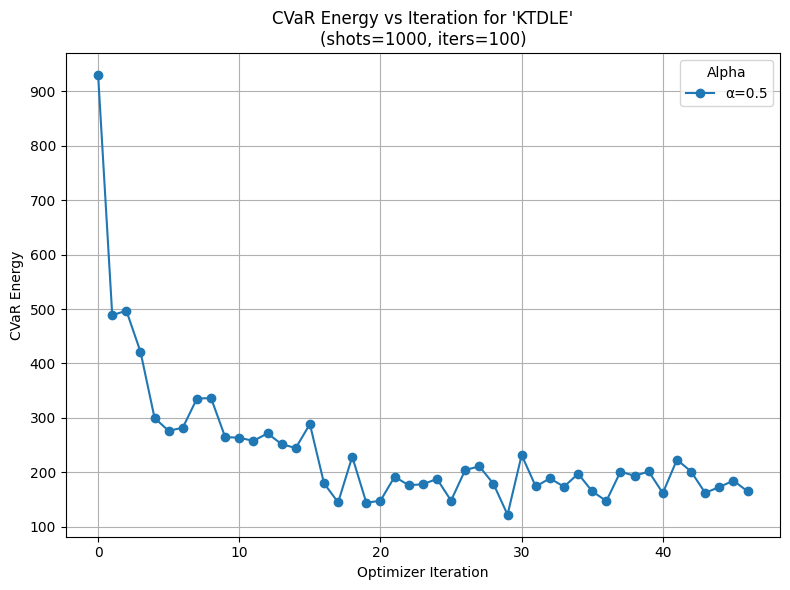

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ─── 1) Print amino acid codes ────────────────────────────────────────────────
letter_to_name = {
    'C': 'Cysteine',
    'M': 'Methionine',
    'F': 'Phenylalanine',
    'I': 'Isoleucine',
    'L': 'Leucine',
    'V': 'Valine',
    'W': 'Tryptophan',
    'Y': 'Tyrosine',
    'H': 'Histidine',
    'P': 'Proline',
    'G': 'Glycine',
    'A': 'Alanine',
    'S': 'Serine',
    'T': 'Threonine',
    'D': 'Aspartate',
    'E': 'Glutamate',
    'K': 'Lysine',
    'R': 'Arginine',
    'Q': 'Glutamine',
    'N': 'Asparagine'
}

print("Single‑letter amino acid codes:")
for letter, name in letter_to_name.items():
    print(f"  {letter}: {name}")
print()

# ─── 2) Ask user for sequence ─────────────────────────────────────────────────
sequence = input("Enter your amino acid sequence (e.g. ACDEFG): ").strip().upper()
# optional validation:
for ch in sequence:
    if ch not in letter_to_name:
        raise ValueError(f"Unknown amino acid letter: {ch}")
print(f"Using sequence: {sequence}\n")

# ─── 3) Ask user which α to run ────────────────────────────────────────────────
choice = input("Enter 'all' to run [1.0, 0.8, 0.6, 0.4, 0.2], or type a single α (e.g. 0.2): ").strip().lower()
if choice == 'all':
    alphas = [1.0, 0.8, 0.6, 0.4, 0.2]
else:
    try:
        a = float(choice)
        if not (0 < a <= 1.0):
            raise ValueError()
        alphas = [a]
    except:
        raise ValueError("Invalid α: must be 'all' or a number between 0 and 1.")
print(f"Running for α = {alphas}\n")

# ─── 4) Simulation parameters ─────────────────────────────────────────────────
n_shots = 1000      # shots per evaluation
maxiter = 100       # COBYLA iterations

# ─── 5) Run CVaR‑VQE for each α ────────────────────────────────────────────────
energy_traces = {}

for alpha in alphas:
    print(f"→ Running CVaR‑VQE for α = {alpha}")
    ham = Hamiltonian(sequence)
    vqe = CVARVQE(ham, alpha=alpha)

    energies = []
    def record_energy(xk):
        energies.append(vqe.evaluate_energy(xk, n_shots=n_shots))

    # initial random guess + record its energy
    init_params = np.random.uniform(0, 2*np.pi, 2 * vqe.n_qubits)
    energies.append(vqe.evaluate_energy(init_params, n_shots=n_shots))

    # optimize with COBYLA, recording at each iteration
    minimize(
        vqe.evaluate_energy,
        init_params,
        method="COBYLA",
        options={"maxiter": maxiter, "disp": False},
        callback=record_energy
    )

    energy_traces[alpha] = energies
    print(f"  Completed {len(energies)-1} steps, final CVaR = {energies[-1]:.2f}\n")

# ─── 6) Plot results ─────────────────────────────────────────────────────────
plt.figure(figsize=(8,6))
for alpha, trace in energy_traces.items():
    plt.plot(range(len(trace)), trace, marker='o', label=f'α={alpha}')
plt.xlabel("Optimizer Iteration")
plt.ylabel("CVaR Energy")
plt.title(f"CVaR Energy vs Iteration for '{sequence}'\n(shots={n_shots}, iters={maxiter})")
plt.legend(title="Alpha")
plt.grid(True)
plt.tight_layout()
plt.show()


Single‑letter codes for amino acids:
  C: Cysteine
  M: Methionine
  F: Phenylalanine
  I: Isoleucine
  L: Leucine
  V: Valine
  W: Tryptophan
  Y: Tyrosine
  H: Histidine
  P: Proline
  G: Glycine
  A: Alanine
  S: Serine
  T: Threonine
  D: Aspartate
  E: Glutamate
  K: Lysine
  R: Arginine
  Q: Glutamine
  N: Asparagine

Enter your amino acid sequence (e.g. ACDEFGH): wfwf

Your sequence residues:
  Position 0: W (Tryptophan)
  Position 1: F (Phenylalanine)
  Position 2: W (Tryptophan)
  Position 3: F (Phenylalanine)

Optimizing CVaR‑VQE (α=0.2, shots=2000, iters=200)...
→ Best CVaR energy from optimizer: -9.4100

→ Lowest‑energy bitstring: 0001 (energy = -9.41)



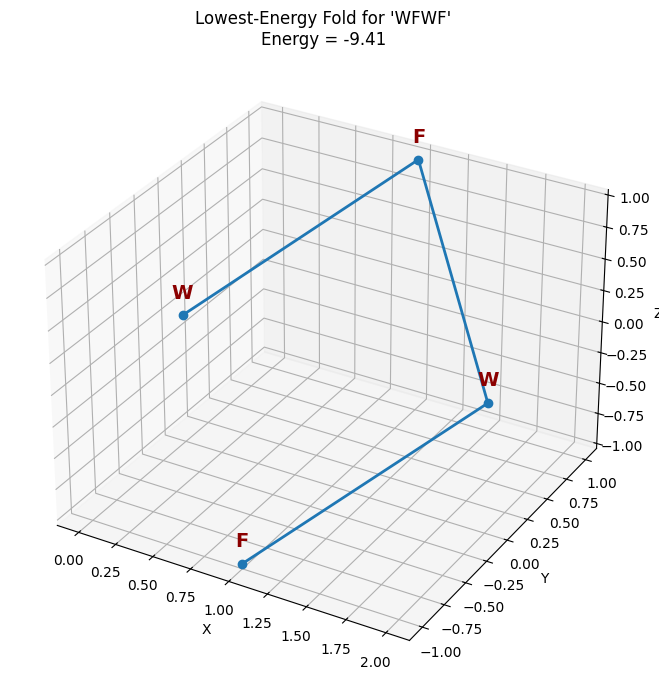

Step lengths: [1.73205081 1.73205081 1.73205081]


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize

# ─── Assumes SparseDiamondEncoder, Hamiltonian, and CVARVQE are already defined ───

# Mapping for full names
letter_to_name = {
    'C': 'Cysteine',     'M': 'Methionine',
    'F': 'Phenylalanine','I': 'Isoleucine',
    'L': 'Leucine',      'V': 'Valine',
    'W': 'Tryptophan',   'Y': 'Tyrosine',
    'H': 'Histidine',    'P': 'Proline',
    'G': 'Glycine',      'A': 'Alanine',
    'S': 'Serine',       'T': 'Threonine',
    'D': 'Aspartate',    'E': 'Glutamate',
    'K': 'Lysine',       'R': 'Arginine',
    'Q': 'Glutamine',    'N': 'Asparagine'
}

# 1) Print the amino acid codes and their names
print("Single‑letter codes for amino acids:")
for letter, name in letter_to_name.items():
    print(f"  {letter}: {name}")
print()

# 2) Get sequence from user
sequence = input("Enter your amino acid sequence (e.g. ACDEFGH): ").strip().upper()
N = len(sequence)

# Validate
for ch in sequence:
    if ch not in letter_to_name:
        raise ValueError(f"Unknown amino acid letter: {ch}")

# 3) Print out the residues in the sequence with their full names
print("\nYour sequence residues:")
for idx, aa in enumerate(sequence):
    print(f"  Position {idx}: {aa} ({letter_to_name[aa]})")
print()

# 4) CVaR‑VQE parameters
alpha    = 0.2        # CVaR tail fraction
n_shots  = 2000       # shots per evaluation
maxiter  = 200        # COBYLA iterations

# 5) Run the VQE optimization
print(f"Optimizing CVaR‑VQE (α={alpha}, shots={n_shots}, iters={maxiter})...")
ham = Hamiltonian(sequence)
vqe = CVARVQE(ham, alpha=alpha)
best_params, best_energy = vqe.optimize(maxiter=maxiter)
print(f"→ Best CVaR energy from optimizer: {best_energy:.4f}\n")

# 6) Measure the ansatz many times and compute each bitstring’s energy
qc = vqe.create_ansatz(best_params)
qc.measure(range(vqe.n_qubits), range(vqe.n_qubits))
job = vqe.backend.run(qc, shots=1000)
counts = job.result().get_counts()

# 7) Find the bitstring with the lowest classical energy
bit_energies = {bs: ham.total_energy(bs) for bs in counts}
best_bitstring = min(bit_energies, key=bit_energies.get)
best_bit_energy = bit_energies[best_bitstring]
print(f"→ Lowest‑energy bitstring: {best_bitstring} (energy = {best_bit_energy:.2f})\n")

# 8) Decode into 3D turns and build coordinates
turns = SparseDiamondEncoder.bitstring_to_turns(best_bitstring, N)
positions = [(0,0,0)]
for t in turns:
    prev = np.array(positions[-1])
    positions.append(tuple(prev + t))
positions = np.array(positions)  # shape (N,3)

# 9) Plot the 3D fold with amino acid labels
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

# Draw backbone
ax.plot(
    positions[:,0], positions[:,1], positions[:,2],
    '-o', linewidth=2, markersize=6, color='tab:blue'
)

# Annotate each bead with its amino‑acid letter, offset slightly in Z
for i, (x, y, z) in enumerate(positions):
    ax.text(
        x, y, z + 0.1,          # lift label 0.1 units above the bead
        sequence[i],            # the single‐letter code
        color='darkred',
        fontsize=14,            # larger font
        fontweight='bold',
        horizontalalignment='center',
        verticalalignment='bottom'
    )

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f"Lowest‑Energy Fold for '{sequence}'\nEnergy = {best_bit_energy:.2f}")
plt.tight_layout()
plt.show()
